# Predicting Income Using Census Dataset

This project is aimed at predicting whether an individual's income is greater than $50K or not using a "Census Income" dataset. The features include age, workclass, education, and race etc. This is a supervised classification problem since the dataset has the ground truth label in the `income` column.

In specific, we need to build a model to predict whether an individual's income is over $50 or not given all the features. Build an accurate model like this can be helpful in data management, e.g. predicting a missing income label.

The dataset was created by Barry Becker and Ronny Kohavi from the 1994 Census database and is downloaded from the UCI ML Repository.

```
Becker,Barry and Kohavi,Ronny. (1996). Adult. UCI Machine Learning Repository. https://doi.org/10.24432/C5XW20.

@misc{misc_adult_2,
  author       = {Becker,Barry and Kohavi,Ronny},
  title        = {{Adult}},
  year         = {1996},
  howpublished = {UCI Machine Learning Repository},
  note         = {{DOI}: https://doi.org/10.24432/C5XW20}
}

```

In [183]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier

from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo

seed = 168
np.random.seed(seed)

# 1. EDA & Data Cleaning

In [47]:
# fetch dataset
adult = fetch_ucirepo(id=2)

# data (as pandas dataframes)
X = adult.data.features
y = adult.data.targets

In [48]:
X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [49]:
y.head()

,income
0,<=50K
1,<=50K
2,<=50K
3,<=50K
4,<=50K


In [50]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
dtypes: int64(6), object(8)
memory usage: 5.2+ MB


There are several features that have missing values and need to be dealt with. Let's check the percentage:

In [51]:
X.isnull().mean()

age               0.000000
workclass         0.019717
fnlwgt            0.000000
education         0.000000
education-num     0.000000
marital-status    0.000000
occupation        0.019778
relationship      0.000000
race              0.000000
sex               0.000000
capital-gain      0.000000
capital-loss      0.000000
hours-per-week    0.000000
native-country    0.005610
dtype: float64

Next, examine general data characteristics and make plots to identify potential data issues, such as outliers.

In [52]:
X.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [175]:
X.dtypes

age                int64
workclass         object
fnlwgt             int64
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
dtype: object

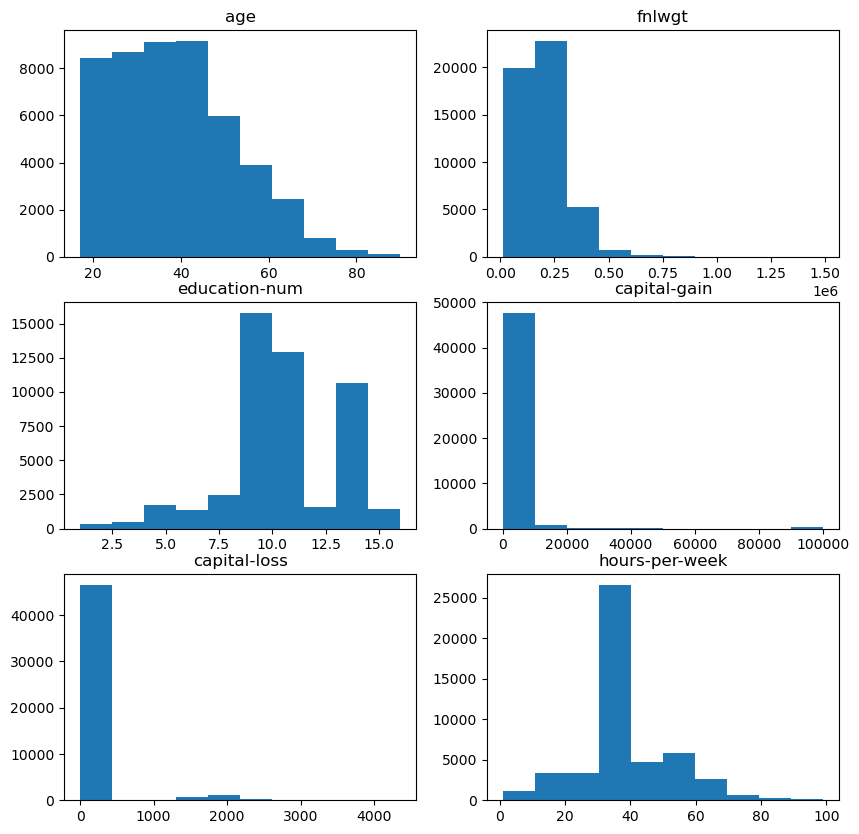

In [191]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
axes = axes.flatten()
i = 0

for feature, dtype in X.dtypes.items():
    if dtype != 'object':
        axes[i].hist(X[feature])
        axes[i].set_title(feature)
        i += 1
        
plt.show()

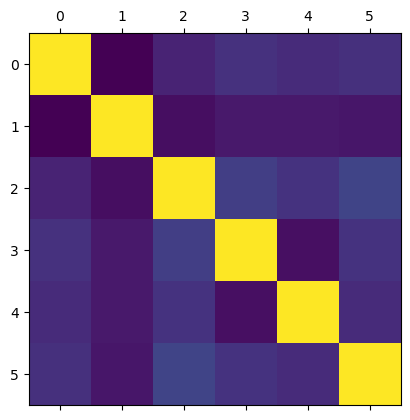

In [199]:
# correlation matrix
X_numeric = X[[k for k, v in X.dtypes.items() if v!='object']]
plt.matshow(X_numeric.corr())

The distributions are not symetrical, thus we'll use median to impute missing values for numeric features.

In [68]:
X.query('education=="Bachelors"')['education-num'].unique()

array([13])

In [69]:
X.query('education=="Some-college"')['education-num'].unique()

array([10])

In [70]:
X.query('education=="Masters"')['education-num'].unique()

array([14])

`education` and `education-num` features are thus interchangeable, and we'll only keep `education-num`.

In [71]:
X.drop(columns=['education'], inplace=True)
X

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States
48838,64,NaN,321403,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States
48839,38,Private,374983,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States
48840,44,Private,83891,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States


Next, check the labels.

In [53]:
y.income.value_counts(normalize=True)

income
<=50K     0.506122
<=50K.    0.254596
>50K      0.160538
>50K.     0.078744
Name: proportion, dtype: float64

Now consolidate the labels and convert to binary labels.

In [54]:
y = y.income.replace({'<=50K.': '<=50K', '>50K.': '>50K'})

In [55]:
y.value_counts(normalize=True)

income
<=50K    0.760718
>50K     0.239282
Name: proportion, dtype: float64

In [56]:
le = LabelEncoder()
le.fit(y)
le.classes_

array(['<=50K', '>50K'], dtype=object)

In [57]:
y = le.transform(y)

We split the data into train, validate and test sets. As the data is imbalanced, we need to make sure the splitting is stratified based on the labels.

In [72]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=seed, 
    shuffle=True, 
    stratify=y
)

In [73]:
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(
    X_train, y_train, 
    test_size=0.25, 
    random_state=seed, 
    shuffle=True, 
    stratify=y_train
)

In [74]:
y.mean()

0.23928176569346055

In [75]:
y_train.mean()

0.23927820698315636

In [76]:
y_test.mean()

0.23929244124150356

In [77]:
y_train_train.mean(), y_train_val.mean()

(0.2392894842208714, 0.23924437650141953)

Finally, we impute the data. For numeric features, we use the median, for categorical features, we use the mode.

In [82]:
numeric_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', ]
categorical_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

In [84]:
X[categorical_features]

,workclass,marital-status,occupation,relationship,race,sex,native-country
0,State-gov,Never-married,Adm-clerical,Not-in-family,White,Male,United-States
1,Self-emp-not-inc,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
2,Private,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States
3,Private,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States
4,Private,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba
...,...,...,...,...,...,...,...
48837,Private,Divorced,Prof-specialty,Not-in-family,White,Female,United-States
48838,NaN,Widowed,NaN,Other-relative,Black,Male,United-States
48839,Private,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States
48840,Private,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,United-States


In [106]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")), 
        #("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")), 
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        #("selector", SelectPercentile(chi2, percentile=50)),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [107]:
preprocessor.fit_transform(X_train.sample(10))

array([[4.80000e+01, 3.44415e+05, 1.30000e+01, 0.00000e+00, 0.00000e+00,
        3.70000e+01, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00],
       [3.30000e+01, 6.31840e+04, 9.00000e+00, 0.00000e+00, 0.00000e+00,
        4.00000e+01, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00],
       [6.70000e+01, 1.62009e+05, 6.00000e+00, 0.00000e+00, 0.00000e+00,
        1.60000e+01, 0.00000e+00, 1.00000e+00, 0.

In [129]:
sample_size = 1000
sample_idx = np.random.randint(low=0, high=X_train_train.shape[0], size=sample_size)
X_sample, y_sample = X_train_train.iloc[sample_idx, :], y_train_train[sample_idx]

In [130]:
X_sample.shape, y_sample.shape

((1000, 13), (1000,))

In [140]:
train_X = preprocessor.fit_transform(X_train_train)
val_X = preprocessor.transform(X_train_val)
train_y, val_y = y_train_train, y_train_val

# 2. Modeling

First, let's spot-check different types of algorithms to see which one works best with this dataset.

In [145]:
algos = {
    'lr': LogisticRegression(),
    'sgd': SGDClassifier(),
    'rg': RidgeClassifier(),
    'svc': SVC(),
    'dt': DecisionTreeClassifier(),
    'gnb': GaussianNB(),
    'knn': KNeighborsClassifier(),
    'gb': GradientBoostingClassifier(),
    'rf': RandomForestClassifier(),
    'bg': BaggingClassifier()
}

results = {}

for algo, clf in algos.items():
    try:
        clf.fit(train_X, train_y)
        score = clf.score(val_X, val_y)
        results[algo] = score
    except:
        results[algo] = None

In [148]:
pd.Series(results).sort_values(ascending=False)

gb     0.863944
rf     0.852042
bg     0.848439
rg     0.829220
dt     0.810002
lr     0.797117
svc    0.796244
knn    0.776916
sgd    0.239244
gnb         NaN
dtype: float64

Ensemble models seem to be the top performers, out of which Gradient Boosting is the best.

Next, add standard scaling to numeric features and test again.

In [149]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")), 
        ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")), 
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        #("selector", SelectPercentile(chi2, percentile=50)),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

train_X = preprocessor.fit_transform(X_train_train)
val_X = preprocessor.transform(X_train_val)
train_y, val_y = y_train_train, y_train_val

results = {}

for algo, clf in algos.items():
    try:
        clf.fit(train_X, train_y)
        score = clf.score(val_X, val_y)
        results[algo] = score
    except:
        results[algo] = None

pd.Series(results).sort_values(ascending=False)

/home/george/anaconda3/envs/ml-project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


gb     0.863944
svc    0.857938
rf     0.854117
lr     0.851059
sgd    0.848329
bg     0.847347
rg     0.839048
knn    0.832605
dt     0.811422
gnb         NaN
dtype: float64

The effect is negligible, so we'll skip standard scaling. Now use the Gradient Boosting algorithm to build the best model by fine tuning hyperparamters.

In [150]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median"))
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")), 
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

train_X = preprocessor.fit_transform(X_train_train)
val_X = preprocessor.transform(X_train_val)
train_y, val_y = y_train_train, y_train_val

In [153]:
%%timeit
# Create the hyperparameters to search over
hyperparameters = {
    'loss': ['log_loss', 'exponential'],
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 0.6, 0.9],
    'n_estimators': [10, 100, 1000],
    'min_samples_split': [2, 3, 4, 5, 6, 10, 20],
    'min_samples_leaf': [1, 2, 3, 5],
    'subsample': [0.1, 0.2, 0.5, 0.6, 0.8, 0.9],
    'max_depth': [1, 2, 3, 4, 5],
    'max_features': ['sqrt', 'log2']
    
}

# Create the cross-validation object
cv = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(),
    param_distributions=hyperparameters,
    n_iter=100,
    cv=5,
    verbose=2,
    random_state=seed
)

# Fit the cross-validation object to the training data
cv.fit(train_X, train_y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END learning_rate=0.1, loss=log_loss, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1000, subsample=0.9; total time=   4.1s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1000, subsample=0.9; total time=   4.1s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1000, subsample=0.9; total time=   4.2s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1000, subsample=0.9; total time=   4.1s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1000, subsample=0.9; total time=   4.1s
[CV] END learning_rate=0.9, loss=log_loss, max_depth=5, max_features=sqrt, min_samples_leaf=

[CV] END learning_rate=0.5, loss=exponential, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=20, n_estimators=100, subsample=0.1; total time=   0.3s
[CV] END learning_rate=0.001, loss=exponential, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=10, subsample=0.5; total time=   0.1s
[CV] END learning_rate=0.001, loss=exponential, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=10, subsample=0.5; total time=   0.1s
[CV] END learning_rate=0.001, loss=exponential, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=10, subsample=0.5; total time=   0.1s
[CV] END learning_rate=0.001, loss=exponential, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=10, subsample=0.5; total time=   0.1s
[CV] END learning_rate=0.001, loss=exponential, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=10, su

[CV] END learning_rate=0.01, loss=exponential, max_depth=1, max_features=log2, min_samples_leaf=3, min_samples_split=20, n_estimators=1000, subsample=0.5; total time=   2.6s
[CV] END learning_rate=0.01, loss=exponential, max_depth=1, max_features=log2, min_samples_leaf=3, min_samples_split=20, n_estimators=1000, subsample=0.5; total time=   2.6s
[CV] END learning_rate=0.01, loss=exponential, max_depth=1, max_features=log2, min_samples_leaf=3, min_samples_split=20, n_estimators=1000, subsample=0.5; total time=   2.7s
[CV] END learning_rate=0.01, loss=exponential, max_depth=1, max_features=log2, min_samples_leaf=3, min_samples_split=20, n_estimators=1000, subsample=0.5; total time=   2.6s
[CV] END learning_rate=0.01, loss=exponential, max_depth=1, max_features=log2, min_samples_leaf=3, min_samples_split=20, n_estimators=1000, subsample=0.5; total time=   2.6s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=

[CV] END learning_rate=0.5, loss=log_loss, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=20, n_estimators=100, subsample=0.6; total time=   0.4s
[CV] END learning_rate=0.6, loss=log_loss, max_depth=4, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.6, loss=log_loss, max_depth=4, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.6, loss=log_loss, max_depth=4, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.6, loss=log_loss, max_depth=4, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.6, loss=log_loss, max_depth=4, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=100, subsample=0.8; total time

[CV] END learning_rate=0.01, loss=exponential, max_depth=4, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=10, subsample=0.1; total time=   0.0s
[CV] END learning_rate=0.01, loss=exponential, max_depth=4, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=10, subsample=0.1; total time=   0.0s
[CV] END learning_rate=0.01, loss=exponential, max_depth=4, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=10, subsample=0.1; total time=   0.0s
[CV] END learning_rate=0.01, loss=exponential, max_depth=4, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=10, subsample=0.1; total time=   0.0s
[CV] END learning_rate=0.6, loss=log_loss, max_depth=4, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=100, subsample=0.5; total time=   0.5s
[CV] END learning_rate=0.6, loss=log_loss, max_depth=4, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=100, subsample=0.5;

[CV] END learning_rate=0.001, loss=exponential, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1000, subsample=0.9; total time=   2.9s
[CV] END learning_rate=0.001, loss=exponential, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1000, subsample=0.9; total time=   2.9s
[CV] END learning_rate=0.001, loss=exponential, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1000, subsample=0.9; total time=   3.0s
[CV] END learning_rate=0.001, loss=exponential, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1000, subsample=0.9; total time=   2.9s
[CV] END learning_rate=0.001, loss=exponential, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1000, subsample=0.9; total time=   2.9s
[CV] END learning_rate=0.01, loss=log_loss, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators

[CV] END learning_rate=0.5, loss=log_loss, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000, subsample=0.8; total time=   6.0s
[CV] END learning_rate=0.5, loss=log_loss, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000, subsample=0.8; total time=   6.5s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, subsample=0.2; total time=   0.0s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, subsample=0.2; total time=   0.0s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, subsample=0.2; total time=   0.0s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, subsample=0.2; total time=  

[CV] END learning_rate=0.1, loss=log_loss, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=100, subsample=0.1; total time=   0.3s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=100, subsample=0.1; total time=   0.3s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=100, subsample=0.1; total time=   0.3s
[CV] END learning_rate=0.9, loss=log_loss, max_depth=4, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, subsample=0.2; total time=   3.8s
[CV] END learning_rate=0.9, loss=log_loss, max_depth=4, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, subsample=0.2; total time=   3.9s
[CV] END learning_rate=0.9, loss=log_loss, max_depth=4, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, subsample=0.2; total

[CV] END learning_rate=0.5, loss=exponential, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000, subsample=0.9; total time=   2.5s
[CV] END learning_rate=0.5, loss=exponential, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000, subsample=0.9; total time=   2.5s
[CV] END learning_rate=0.5, loss=exponential, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000, subsample=0.9; total time=   2.4s
[CV] END learning_rate=0.5, loss=exponential, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000, subsample=0.9; total time=   2.4s
[CV] END learning_rate=0.9, loss=exponential, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.9, loss=exponential, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10, su

[CV] END learning_rate=0.1, loss=exponential, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=100, subsample=0.6; total time=   0.4s
[CV] END learning_rate=0.001, loss=exponential, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.001, loss=exponential, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.001, loss=exponential, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.001, loss=exponential, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.001, loss=exponential, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100

[CV] END learning_rate=0.6, loss=log_loss, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=1000, subsample=0.2; total time=   3.3s
[CV] END learning_rate=0.6, loss=log_loss, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=1000, subsample=0.2; total time=   3.4s
[CV] END learning_rate=0.6, loss=log_loss, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=1000, subsample=0.2; total time=   3.3s
[CV] END learning_rate=0.6, loss=log_loss, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=1000, subsample=0.2; total time=   3.4s
[CV] END learning_rate=0.6, loss=log_loss, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=1000, subsample=0.2; total time=   3.4s


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=100,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1, 0.5,
                                                          0.6, 0.9],
                                        'loss': ['log_loss', 'exponential'],
                                        'max_depth': [1, 2, 3, 4, 5],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 3, 5],
                                        'min_samples_split': [2, 3, 4, 5, 6, 10,
                                                              20],
                                        'n_estimators': [10, 100, 1000],
                                        'subsample': [0.1, 0.2, 0.5, 0.6, 0.8,
                                                      0.9]},
                   random_state=168, verbose=2)

In [154]:
# Print results
print(f'Best score: {cv.best_score_} achieved with params: \n{cv.best_params_}')

Best score: 0.869071449605211 achieved with params: 
{'subsample': 0.9, 'n_estimators': 1000, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 3, 'loss': 'log_loss', 'learning_rate': 0.1}


Train the final model:

In [163]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [164]:
clf = GradientBoostingClassifier(**cv.best_params_)
clf.fit(X_train, y_train)

GradientBoostingClassifier(max_features='sqrt', min_samples_split=4,
                           n_estimators=1000, subsample=0.9)

# 3. Results

Test the final model using the test set:

In [165]:
clf.score(X_test, y_test)

0.8751126033903858

# 4. Conclusion

A major takeaway is that scaling numeric data doesn't necessarily help improve the model performance. This is probably due to the fact that the data range is not drastically different. 

To further improve the model's performance, we can use the cross-validation testing harness designed to test more different configurations, e.g. feature selection, other imputation strategies and tune even more hyperparameters with more options.